# Testing OOD of env images w.r.t. CLIP

One hypothesis for the lack of similarity between goal description and goal image is that the images are simply out of distribution/domain for CLIP, given that they are images of an RL environment. We hypothesize that images of RL environments made up a negligible portion of the CLIP visual training data, and that as such CLIP will struggle to properly encode these kinds of images.

To test this, we want to see if making the images more realistic with Stable Diffusion will lead to an increase in similarity between text and image. If this is the case, then we have some evidence that indeed our original images were OOD.

## Setting up

In [1]:
import torch
import gc

In [2]:
# set this to 'cpu' for CPU and 'cuda' for GPU
device = "cuda"

In [3]:
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True

In [4]:
def clear_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()  # https://forums.fast.ai/t/clearing-gpu-memory-pytorch/14637
    gc.collect()

In [5]:
!pip install diffusers['torch'] transformers accelerate xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [6]:
import diffusers
import transformers
from PIL import Image
import numpy as np
import os
import torch

## Data

In [7]:
!mkdir lang_annotations

mkdir: cannot create directory ‘lang_annotations’: File exists


In [8]:
DATA_PATH = "."
# train_path = os.path.join(DATA_PATH, ".")
train_path = "."

In [9]:
# this is an object array so we need to pass allow_pickle=True

lang_annotations = np.load(
    os.path.join(train_path, "lang_annotations", "auto_lang_ann.npy"), allow_pickle=True
)
lang_annotations_dict = lang_annotations.item()

In [10]:
# get array images
# the images we are interested in are the ones at the end of the task trajectories
# as specified by the language annotations

image_idxs = [end for (start, end) in lang_annotations_dict["info"]["indx"]]

images = [
    Image.fromarray(
        np.load(os.path.join(train_path, f"episode_0{idx}.npz"))["rgb_static"]
    )
    for idx in image_idxs
]

In [11]:
# get language_annotations
lang_anns = lang_annotations_dict["language"]["ann"]

## Diffusion

In [12]:
# our diffusion pipeline needs to change now:

img2img_tg = diffusers.StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None
)
# memory optimizations
img2img_tg.enable_model_cpu_offload()
img2img_tg.enable_xformers_memory_efficient_attention()

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### Getting the settings right

In [13]:
env_image = images[0].resize((768, 768))

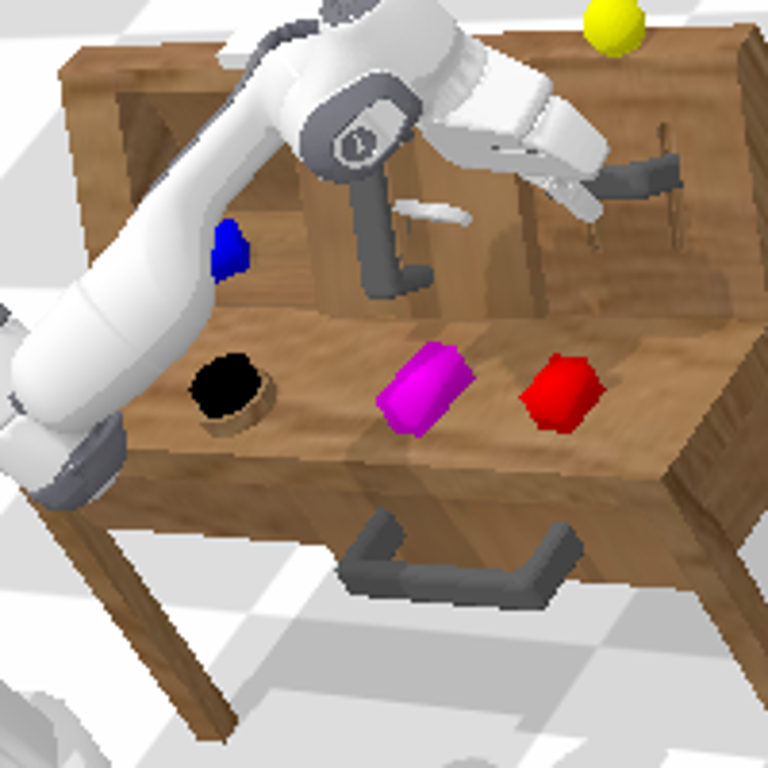

In [14]:
env_image

In [15]:
prompt = "Photograph of robotic arm interacting with wooden table top. Canon 60D. Realistic, HD, 8k, ultra detailed"

In [16]:
generator = torch.Generator(device=device).manual_seed(1024)

In [17]:
# note: i played around with the parameters a bit here
output = img2img_tg(
    prompt=prompt,
    image=env_image,
    strength=0.35,
    guidance_scale=50,
    generator=generator,
    num_inference_steps=200,
)

  0%|          | 0/70 [00:00<?, ?it/s]

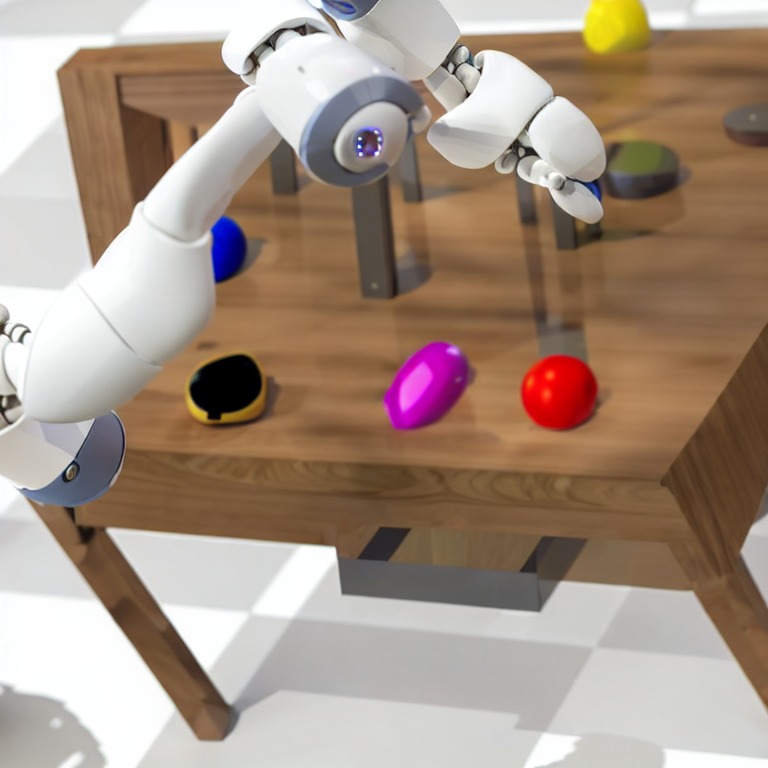

In [18]:
output.images[0]

### Generating batch of realistic images

In [19]:
from tqdm import tqdm

In [20]:
synthreal_images = [
    img2img_tg(
        prompt=prompt,
        image=image.resize((768, 768)),
        strength=0.35,
        guidance_scale=50,
        generator=generator,
        num_inference_steps=200,
    ).images[0]
    for image in tqdm(images)
]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:31<04:12, 31.52s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [01:02<03:39, 31.36s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [01:33<03:07, 31.27s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [02:05<02:35, 31.19s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [02:36<02:04, 31.17s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [03:07<01:33, 31.13s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 78%|███████▊  | 7/9 [03:38<01:02, 31.34s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

 89%|████████▉ | 8/9 [04:10<00:31, 31.26s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 9/9 [04:41<00:00, 31.24s/it]


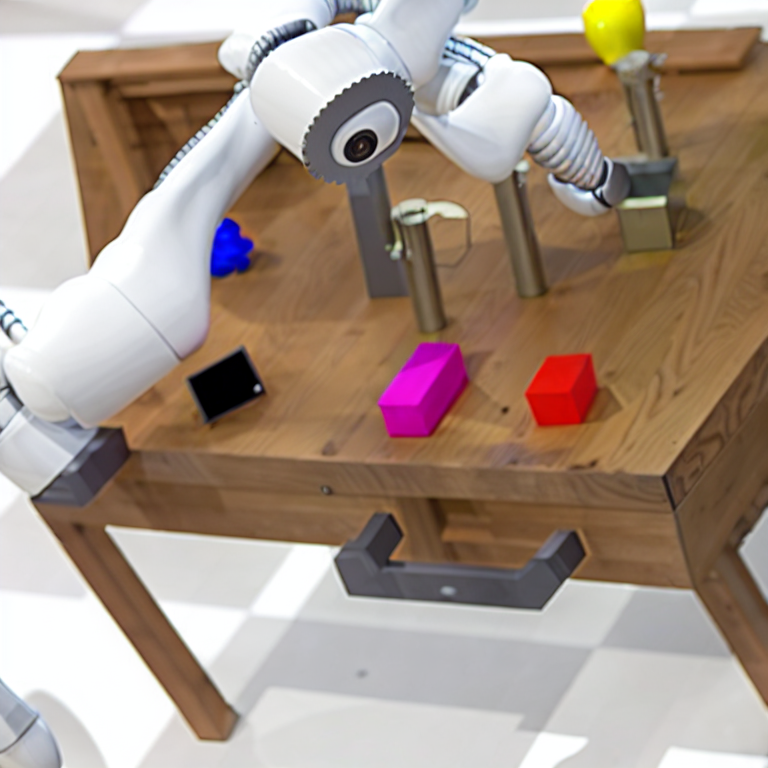

In [21]:
# example image
synthreal_images[0]

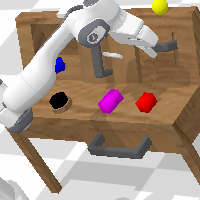

In [22]:
# vs original
images[0]

## Check CLIP Similarity

In [23]:
MODEL_VARIANT = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"

clip_model = transformers.CLIPModel.from_pretrained(MODEL_VARIANT)
clip_processor = transformers.CLIPProcessor.from_pretrained(MODEL_VARIANT)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [24]:
prefix = "Robotic arm interacting with wooden tabletop environment. "
prompt_engineered_lang_anns = [prefix + lang_ann for lang_ann in lang_anns]

In [25]:
orig_inputs = clip_processor(
    text=prompt_engineered_lang_anns,
    images=images,
    padding=True,
    return_tensors="pt",
)
synthreal_inputs = clip_processor(
    text=prompt_engineered_lang_anns,
    images=synthreal_images,
    padding=True,
    return_tensors="pt",
)


with torch.no_grad():
    print("original")
    orig_outputs = clip_model(**orig_inputs)
    print("synthreal")
    synthreal_outputs = clip_model(**synthreal_inputs)

print("done")

orig_logits_per_text = orig_outputs["logits_per_image"].T
synthreal_logits_per_text = synthreal_outputs["logits_per_image"].T

original
synthreal
done


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

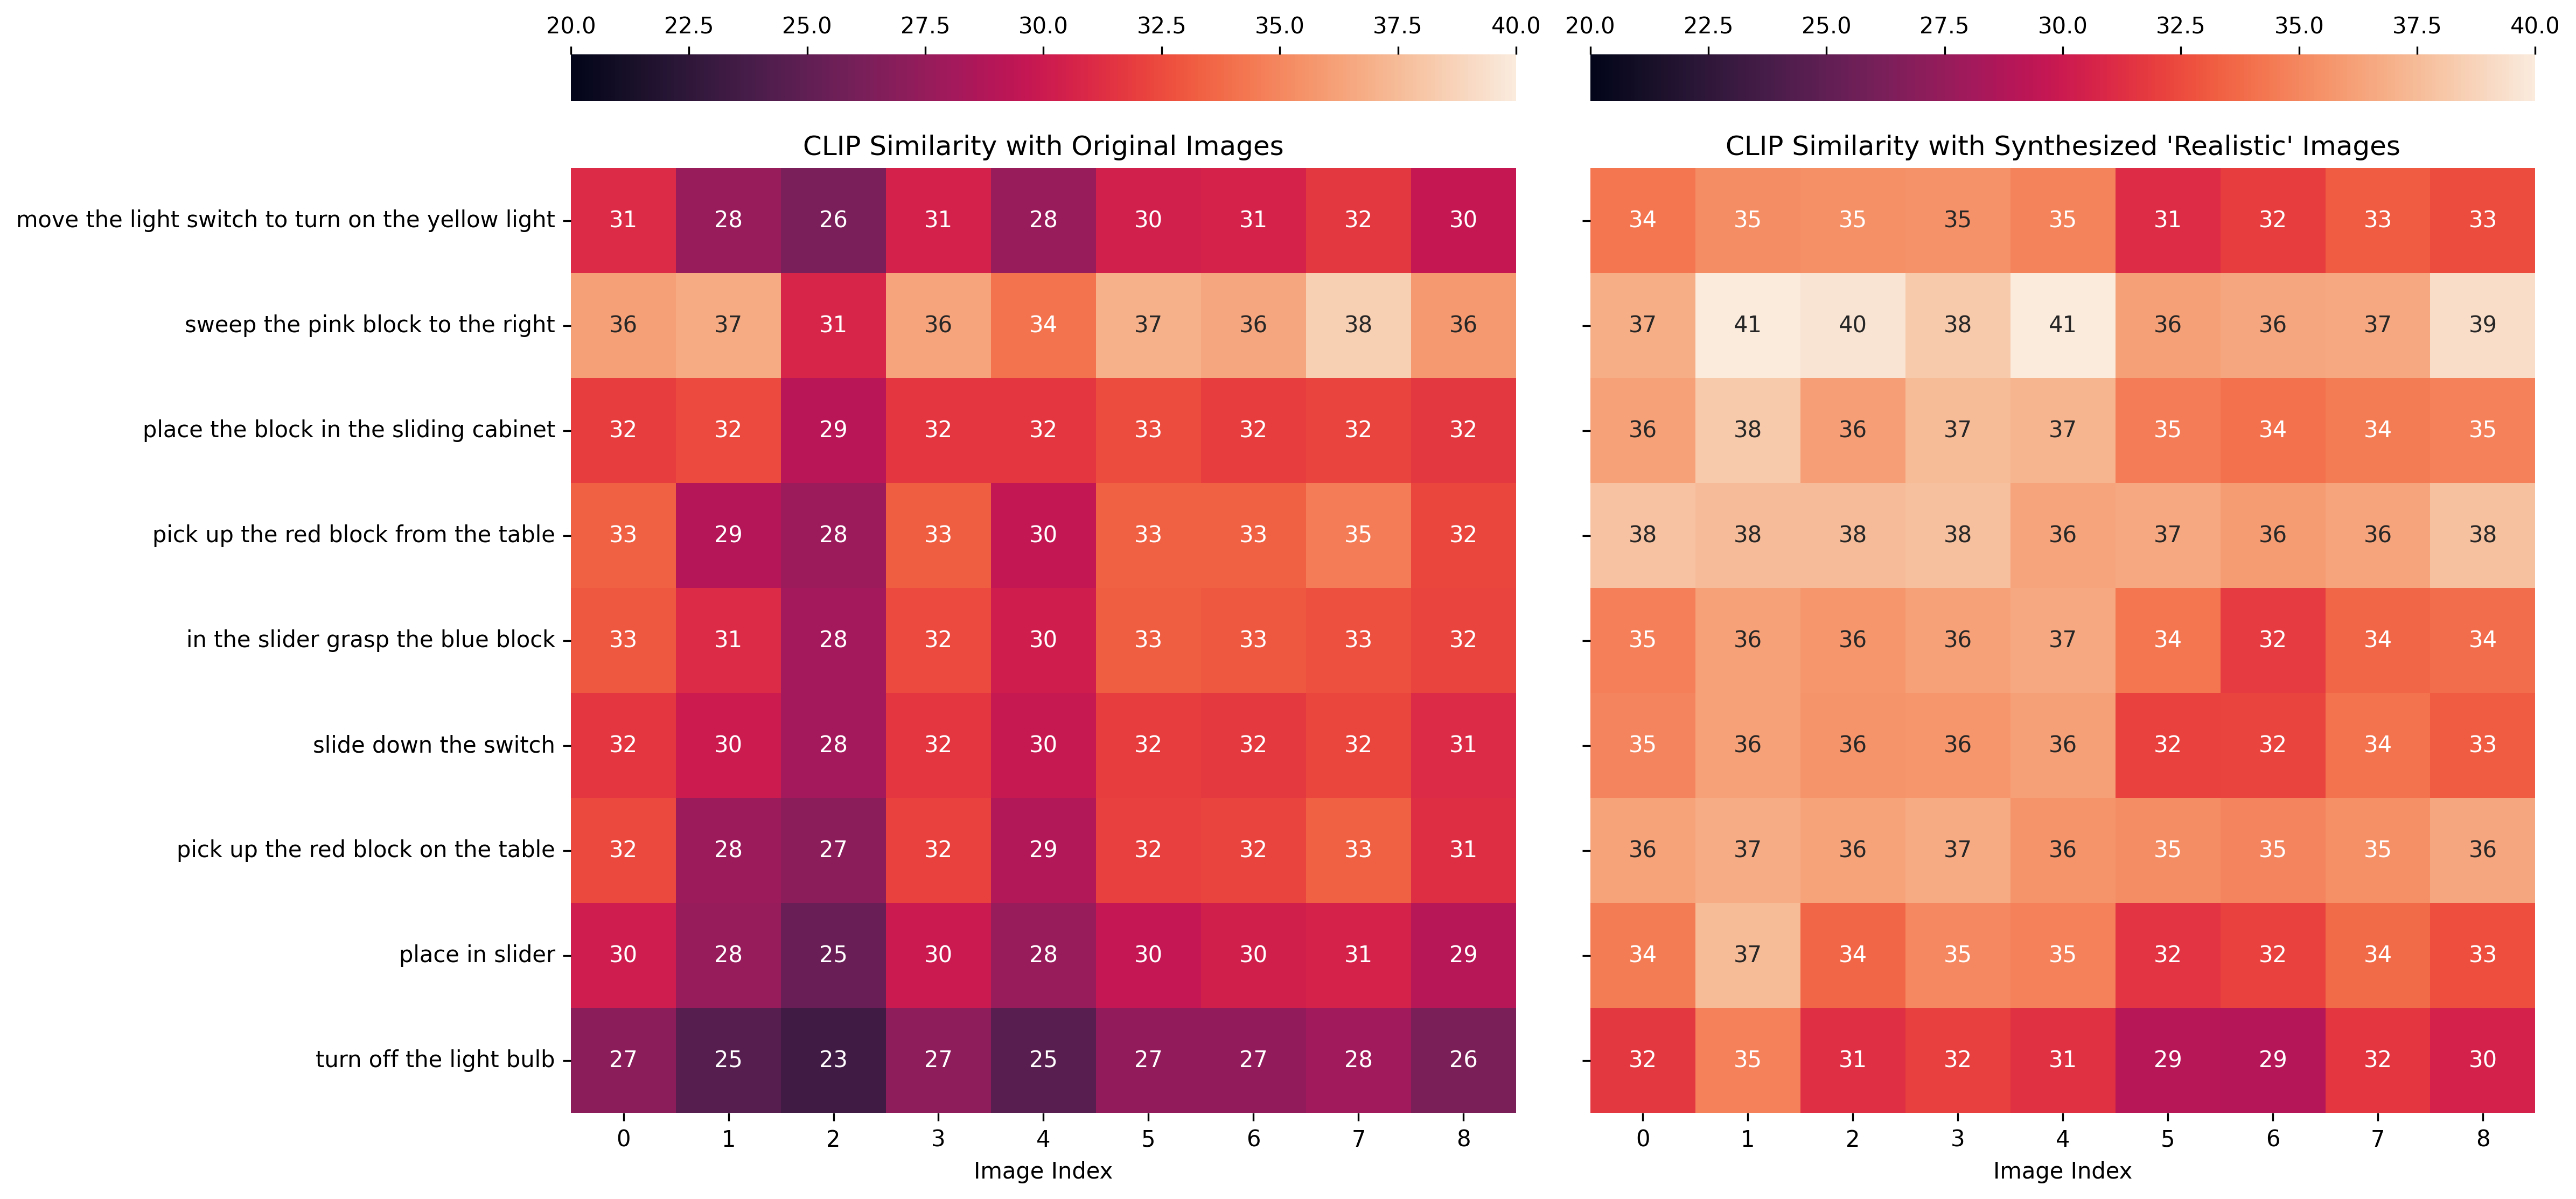

In [27]:
# and plot

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=300, sharey=True)
ax1 = sns.heatmap(
    orig_logits_per_text,
    ax=ax1,
    yticklabels=lang_anns,
    vmin=20,
    vmax=40,
    square=True,
    annot=True,
    cbar_kws={"orientation": "horizontal", "location": "top"},
)
ax1.set_xlabel("Image Index")
ax1.set_title("CLIP Similarity with Original Images")

ax2 = sns.heatmap(
    synthreal_logits_per_text,
    ax=ax2,
    yticklabels=lang_anns,
    vmin=20,
    vmax=40,
    square=True,
    annot=True,
    cbar_kws={"orientation": "horizontal", "location": "top"},
)
ax2.set_xlabel("Image Index")
ax2.set_title("CLIP Similarity with Synthesized 'Realistic' Images")
f.set_tight_layout(True)
plt.show()

In [28]:
print("mean", orig_logits_per_text.mean())
print("median", orig_logits_per_text.median())
print("max", orig_logits_per_text.max())
print("min", orig_logits_per_text.min())
print("std", orig_logits_per_text.std())

mean tensor(30.8131)
median tensor(31.0789)
max tensor(38.4459)
min tensor(23.4024)
std tensor(3.0150)


In [29]:
print("mean", synthreal_logits_per_text.mean())
print("median", synthreal_logits_per_text.median())
print("max", synthreal_logits_per_text.max())
print("min", synthreal_logits_per_text.min())
print("std", synthreal_logits_per_text.std())

mean tensor(35.0411)
median tensor(35.3157)
max tensor(40.7998)
min tensor(28.8632)
std tensor(2.4296)


While there's certainly no diagonal to be seen, we do indeed notice an increase in similarity between text and image when using synthesized "realistic" images, indicating that the original images may indeed have been OOD.